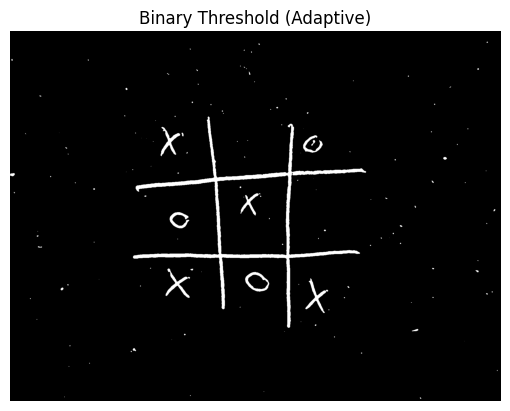

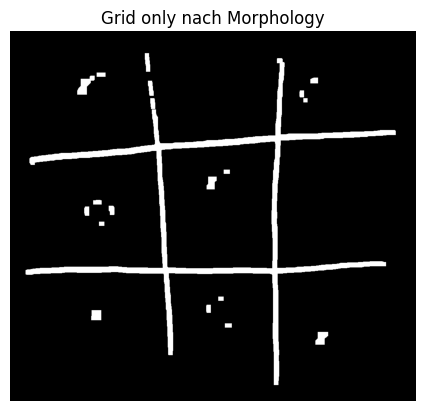

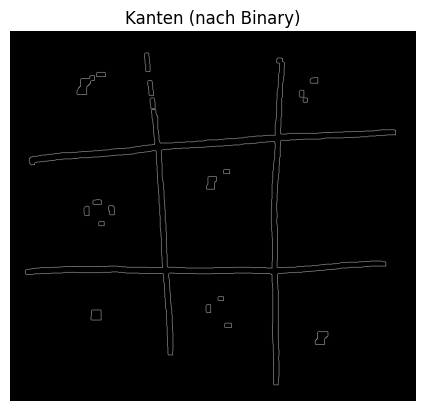

Gefundene Linien (roh): 121
Gefundene Linien (gefiltert): 12


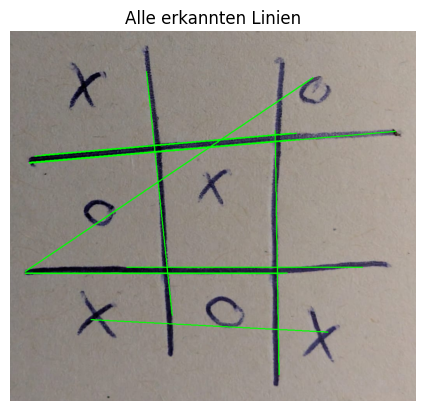

x-Koordinaten (ungeclustert): [384, 687]
x-Koordinaten (geclustert): [384, 687]
y-Koordinaten (ungeclustert): [299, 309, 292, 309, 623, 624, 291, 759, 608]
y-Koordinaten (geclustert): [300, 608, 623, 759]


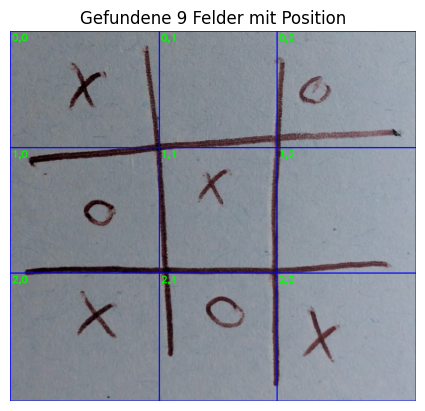

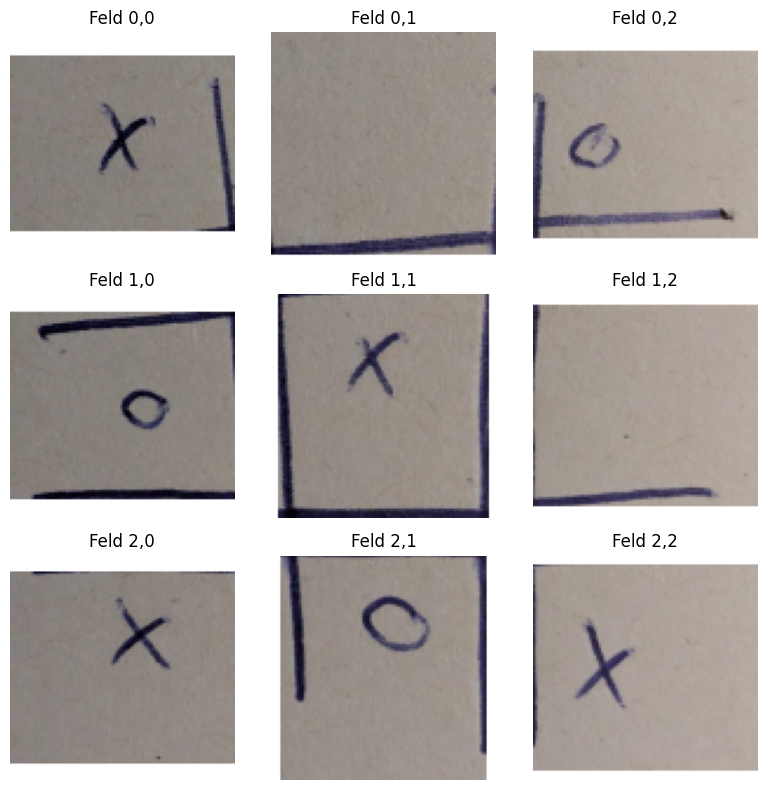

In [84]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage import color

def show_image(image, title=None):
    plt.imshow(image, cmap='gray')
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

def cluster_coords(coords, mindist=20):
    if not coords:
        return []
    coords = sorted(coords)
    clustered = []
    current_cluster = [coords[0]]
    for c in coords[1:]:
        if abs(c - current_cluster[-1]) < mindist:
            current_cluster.append(c)
        else:
            clustered.append(int(np.mean(current_cluster)))
            current_cluster = [c]
    clustered.append(int(np.mean(current_cluster)))
    return clustered

def get_two_most_centered(coords, img_size):
    if len(coords) < 2:
        return None
    targets = [img_size // 3, 2 * img_size // 3]
    selected = []
    coords = sorted(coords)
    for t in targets:
        best = min(coords, key=lambda c: abs(c - t))
        selected.append(best)
        coords = [c for c in coords if c != best]
    return sorted(selected)

def get_line_centers(lines, img_size, axis='x'):
    coords = []
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            if axis == 'x':
                if abs(x1 - x2) < img_size * 0.15:
                    coords.append(int((x1 + x2) / 2))
            else:
                if abs(y1 - y2) < img_size * 0.15:
                    coords.append(int((y1 + y2) / 2))
    if axis == 'y':
        clustered = cluster_coords(coords, mindist=15)
    else:
        clustered = cluster_coords(coords, mindist=int(img_size * 0.04))
    print(f"{axis}-Koordinaten (ungeclustert):", coords)
    print(f"{axis}-Koordinaten (geclustert):", clustered)
    return clustered

def filter_longest_lines(lines, num=12):
    if lines is None or len(lines) == 0:
        return []
    lines = [line[0] for line in lines]
    lines = sorted(lines, key=lambda l: (l[2]-l[0])**2 + (l[3]-l[1])**2, reverse=True)
    return np.array([[l] for l in lines[:num]])

def crop_to_largest_contour(binary, original_img):
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return binary, original_img
    largest = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest)
    pad = int(0.04 * max(w, h))
    x = max(0, x-pad)
    y = max(0, y-pad)
    w = min(binary.shape[1]-x, w+2*pad)
    h = min(binary.shape[0]-y, h+2*pad)
    binary_cropped = binary[y:y+h, x:x+w]
    img_cropped = original_img[y:y+h, x:x+w]
    return binary_cropped, img_cropped

def detect_tic_tac_toe_grid(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.medianBlur(gray, 7)
    
    # --- Adaptive Threshold statt normalem threshold ---
    binary = cv2.adaptiveThreshold(
        blur,
        maxValue=255,
        adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        thresholdType=cv2.THRESH_BINARY_INV,
        blockSize=51,    # ungerade Zahl, testen: 31-55
        C=7
    )
    show_image(binary, "Binary Threshold (Adaptive)")

    binary, img = crop_to_largest_contour(binary, img)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (11,11))
    grid_only = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    grid_only = cv2.morphologyEx(grid_only, cv2.MORPH_OPEN, kernel)
    show_image(grid_only, "Grid only nach Morphology")

    edges = cv2.Canny(grid_only, 20, 70, apertureSize=3)
    show_image(edges, "Kanten (nach Binary)")

    height, width = grid_only.shape
    min_dim = min(height, width)
    minLineLength = int(min_dim * 0.10)
    maxLineGap = int(min_dim * 0.25)

    lines = cv2.HoughLinesP(
        edges,
        rho=1,
        theta=np.pi / 180,
        threshold=10,
        minLineLength=minLineLength,
        maxLineGap=maxLineGap
    )

    print("Gefundene Linien (roh):", len(lines) if lines is not None else 0)
    lines = filter_longest_lines(lines, num=12)
    print("Gefundene Linien (gefiltert):", len(lines) if lines is not None else 0)

    if lines is not None and len(lines) > 0:
        debug_img = img.copy()
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(debug_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        show_image(cv2.cvtColor(debug_img, cv2.COLOR_BGR2RGB), "Alle erkannten Linien")

    x_centers = get_line_centers(lines, width, axis='x')
    y_centers = get_line_centers(lines, height, axis='y')

    vx = get_two_most_centered(x_centers, width)
    hy = get_two_most_centered(y_centers, height)

    x_coords = [0] + vx + [width] if vx else []
    y_coords = [0] + hy + [height] if hy else []

    if len(x_coords) != 4 or len(y_coords) != 4:
        print(f"Fehler: Koordinatenlisten falsch! x: {x_coords}, y: {y_coords}")
        print("Kann Felder nicht sauber extrahieren. Abbruch.")
        return [], []

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_grid = img_rgb.copy()
    field_bilder = []
    positionen = []

    for row in range(3):
        for col in range(3):
            x1, x2 = x_coords[col], x_coords[col+1]
            y1, y2 = y_coords[row], y_coords[row+1]
            feld = img[y1:y2, x1:x2]
            field_bilder.append(feld)
            positionen.append((row, col))
            cv2.rectangle(img_grid, (x1, y1), (x2, y2), (255,0,0), 2)
            cv2.putText(img_grid, f"{row},{col}", (x1+5, y1+25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)

    show_image(cv2.cvtColor(img_grid, cv2.COLOR_BGR2RGB), "Gefundene 9 Felder mit Position")
    return field_bilder, positionen

def crop_and_resize_field(field_img, size=96, pad_color=(255,255,255)):
    h, w = field_img.shape[:2]
    scale = size / max(h, w)
    new_h, new_w = int(h*scale), int(w*scale)
    resized = cv2.resize(field_img, (new_w, new_h), interpolation=cv2.INTER_AREA)
    result = np.full((size, size, 3), pad_color, dtype=np.uint8)
    y_start = (size - new_h) // 2
    x_start = (size - new_w) // 2
    result[y_start:y_start+new_h, x_start:x_start+new_w] = resized
    return result

def show_9_fields(field_bilder, positionen, size=96):
    if not field_bilder or not positionen:
        print("Keine Felder zum Anzeigen!")
        return
    fig, axs = plt.subplots(3, 3, figsize=(8, 8))
    for idx, (feld, pos) in enumerate(zip(field_bilder, positionen)):
        row, col = pos
        norm_feld = crop_and_resize_field(feld, size=size)
        axs[row, col].imshow(cv2.cvtColor(norm_feld, cv2.COLOR_BGR2RGB))
        axs[row, col].set_title(f"Feld {row},{col}")
        axs[row, col].axis('off')
    plt.tight_layout()
    plt.show()

# ---- Beispiel-Aufruf ----
field_bilder, positionen = detect_tic_tac_toe_grid('Filled_Field2.png')
show_9_fields(field_bilder, positionen, size=96)


Image is messy: 3 clusters explain better than 2 but further analysis needed.
Angle difference is not ~90°: [np.float64(43.5), np.float64(167.14545454545453)]
Line Score: False, Circle Score: 786
Field 0: O
Image is messy: 3 clusters explain better than 2 but further analysis needed.
Angle difference is not ~90°: [np.float64(82.375), np.float64(89.19354838709677)]
Line Score: False, Circle Score: 2269
Field 1: O
Too much angle variety: 3 clusters explain better than 2.
Line Score: False, Circle Score: 615
Field 2: O
Image is messy: 3 clusters explain better than 2 but further analysis needed.
Angle difference is not ~90°: [np.float64(87.44594594594594), np.float64(139.5)]
Line Score: False, Circle Score: 920
Field 3: O
Too much angle variety: 3 clusters explain better than 2.
Line Score: False, Circle Score: 1025
Field 4: O
Image is messy: 3 clusters explain better than 2 but further analysis needed.
Angle difference is not ~90°: [np.float64(82.5), np.float64(88.6)]
Line Score: False, 

ValueError: n_samples=4 should be >= n_clusters=5.

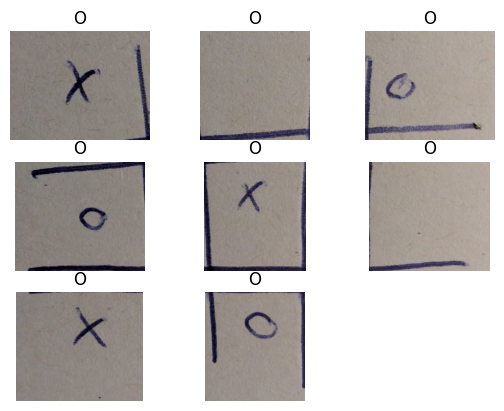

In [85]:
def draw_lines(hough_array, image, threshold_ratio=0.6):
    output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR) if len(image.shape) == 2 else image.copy()
    h, w = hough_array.shape
    img_h, img_w = image.shape[:2]

    max_val = np.max(hough_array)
    threshold = max_val * threshold_ratio

    for r in range(h):
        for theta in range(w):
            if hough_array[r, theta] > threshold:
                angle = theta * np.pi / w
                radius = r - h // 2
                a = np.cos(angle)
                b = np.sin(angle)
                x0 = a * radius + img_w / 2
                y0 = b * radius + img_h / 2

                x1 = int(x0 + 1000 * (-b))
                y1 = int(y0 + 1000 * (a))
                x2 = int(x0 - 1000 * (-b))
                y2 = int(y0 - 1000 * (a))

                cv2.line(output, (x1, y1), (x2, y2), (0, 0, 255), 1)

    show_image(output, "Detected Lines")


def draw_circles(circles, image):
    output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR) if len(image.shape) == 2 else image.copy()
    for x, y, r in circles:
        cv2.circle(output, (x, y), r, (0, 0, 255), 1)
    show_image(output, "Detected Circles")

    


def suppress_if_flat(image, threshold=0.5):
    if image.max() - image.min() < threshold:
        return np.zeros_like(image)
    return image

def convert_to_binary(image):
    if image.shape[-1] == 4:
        image = color.rgba2rgb(image)
    gray_image = color.rgb2gray(image)  # Convert to grayscale
    gray_image = gray_image.astype(np.float32)  # Ensure float type for processing
    blurred = cv2.GaussianBlur(gray_image, (5, 5), 0)  # Apply Gaussian blur
    inverted = 1 - blurred  # Invert the grayscale image
    inverted = suppress_if_flat(inverted)  # Suppress flat areas

    binary_image = inverted > np.max(inverted) * 0.6  
    binary_image_uint8 = (binary_image * 255).astype(np.uint8)
    return binary_image_uint8



def linearHT(im_edge, angle_steps, radius_steps):
    height, width = im_edge.shape

    xCtr = width // 2
    yCtr = height // 2
    nAng = angle_steps
    nRad = radius_steps
    dAng = np.pi / nAng
    rMax = int(np.sqrt((xCtr ** 2) + (yCtr ** 2)))
    dRad = 2 * rMax / nRad
    houghArray = np.zeros((nRad, nAng), dtype=np.int32)

    for v in range(height):
        for u in range(width):
            if im_edge[v, u] > 0:
                x = u - xCtr
                y = v - yCtr
                for i in range(nAng):
                    theta = i * dAng
                    r = int((x * np.cos(theta) + y * np.sin(theta)) / dRad) + nRad // 2
                    if 0 <= r < nRad:
                        houghArray[r, i] += 1

    return houghArray


def circleHT(I, radii_range):

    height, width = I.shape
    accumulator = np.zeros((height, width, len(radii_range)), dtype=np.uint64)

    # Edge points
    edge_points = np.argwhere(I)

    # For each edge point
    for y, x in edge_points:  # image coordinate (row, col) = (y, x)
        for r_idx, r in enumerate(radii_range):
            # Draw a circle centered at every possible (x, y) with radius r
            for theta in range(0, 360, 5):  # 5-degree steps
                a = int(x - r * np.cos(np.deg2rad(theta)))
                b = int(y - r * np.sin(np.deg2rad(theta)))
                if 0 <= a < width and 0 <= b < height:
                    accumulator[b, a, r_idx] += 1

    # Threshold: find local maxima in the accumulator
    threshold = np.max(accumulator) * 0.8  # You can tune this
    circles = []

    for y in range(height):
        for x in range(width):
            for r_idx, r in enumerate(radii_range):
                if accumulator[y, x, r_idx] > threshold:
                    circles.append((x, y, r))

    return circles


def is_possible_x(hough_array, angle_threshold_deg=15, prominence_ratio=0.9, spread_threshold=10, inertia_gap=0.5):
    """
    Accept only if there are 2 strong, compact angle clusters ~90° apart.
    Reject if the angles are scattered or noisy.
    """
    max_val = np.max(hough_array)
    if max_val == 0:
        return False

    height, width = hough_array.shape
    angle_step = 180.0 / width
    threshold = max_val * prominence_ratio

    angles = []
    for r in range(height):
        for theta in range(width):
            if hough_array[r, theta] >= threshold:
                angle_deg = (theta * angle_step) % 180
                angles.append(angle_deg)

    if len(angles) < 4:
        return False

    angles = np.array(angles).reshape(-1, 1)

    # Compare inertia for 1, 2, and 3 clusters
    inertia = []
    for k in [1, 2, 3, 4, 5]:
        kmeans = KMeans(n_clusters=k, n_init='auto', random_state=0).fit(angles)
        inertia.append(kmeans.inertia_)

    # Reject if 3 clusters are significantly better than 2 (i.e., image is messy)
    if len(inertia) >= 3 and inertia[1] - inertia[2] > inertia_gap * inertia[1]:
        if inertia[1] > 10000:
            print("Too much angle variety: 3 clusters explain better than 2.")
            return False
        print("Image is messy: 3 clusters explain better than 2 but further analysis needed.")

    # Now use 2 clusters and validate angle difference
    kmeans = KMeans(n_clusters=2, n_init='auto', random_state=0).fit(angles)
    centers = sorted(kmeans.cluster_centers_.flatten())
    labels = kmeans.labels_

    # Check if clusters are compact (low variance)
    std_devs = []
    for i in [0, 1]:
        cluster_angles = angles[labels == i].flatten()
        std = np.std(cluster_angles)
        std_devs.append(std)
        if std > spread_threshold:
            print(f"Cluster {i} is too spread out: std={std}")
            return False

    # Check angle difference is ~90°
    diff = abs(centers[1] - centers[0])
    diff = min(diff, 180 - diff)
    if abs(diff - 90) > angle_threshold_deg:
        print(f"Angle difference is not ~90°: {centers}")
        return False

    print(f"Valid X detected. Clusters: {centers}, std devs: {std_devs}")
    return True

def classify_cell(cell_img, angle_steps=180, radius_steps=100, radii_range=range(10, 20)):
    """
    Classifies a single tic-tac-toe cell as 'X', 'O', or 'Empty'.
    """

    hough_lines = linearHT(cell_img, angle_steps, radius_steps)
    #hough_lines = non_maximum_suppression(hough_lines, threshold=0.1)  # Apply non-maximum suppression
    hl_max = np.max(hough_lines)
    hough_lines = hough_lines > (hl_max * 0.5)  # Thresholding the Hough lines

    line_score = is_possible_x(hough_lines, angle_threshold_deg=20, prominence_ratio=0.9, spread_threshold=30, inertia_gap=0.5)

    # Apply custom Hough Circle detection
    circles = circleHT(cell_img, radii_range)
    circle_score = len(circles)
    print(f"Line Score: {line_score}, Circle Score: {circle_score}")
    # Decision logic
    if line_score == True :
        return 'X'
    elif circle_score >= 2 and line_score == False:
        return 'O'
    else:
        return 'Empty'


for idx, feld in enumerate(field_bilder):
    # Convert BGR (von OpenCV) nach RGB, falls nötig
    field_rgb = cv2.cvtColor(feld, cv2.COLOR_BGR2RGB)
    binary_img = convert_to_binary(field_rgb)
    klass = classify_cell(binary_img, angle_steps=180, radius_steps=100, radii_range=range(10, 20))
    print(f"Field {idx}: {klass}")
    plt.subplot(3, 3, idx+1)
    plt.imshow(field_rgb)
    plt.title(f"{klass}")
    plt.axis('off')
plt.tight_layout()
plt.show()

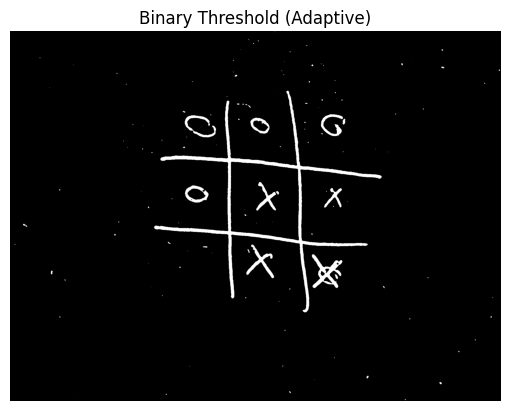

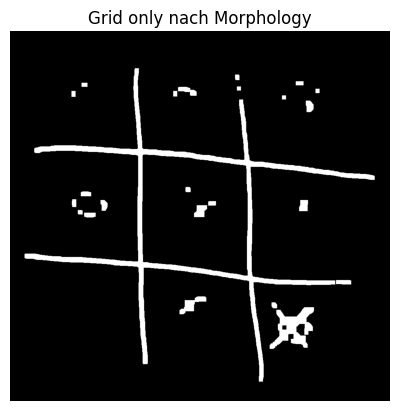

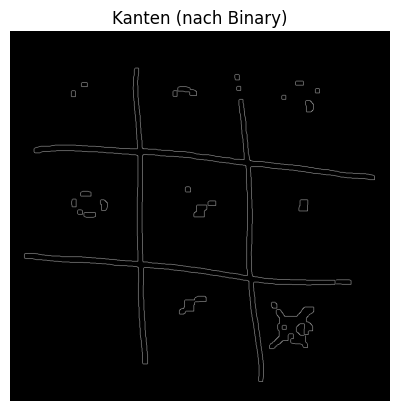

Gefundene Linien (roh): 195
Gefundene Linien (gefiltert): 12


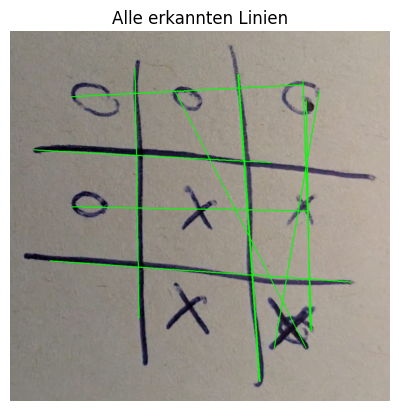

x-Koordinaten (ungeclustert): [642, 641, 640, 769, 797, 340, 800]
x-Koordinaten (geclustert): [340, 641, 788]
y-Koordinaten (ungeclustert): [645, 336, 477, 160]
y-Koordinaten (geclustert): [160, 336, 477, 645]


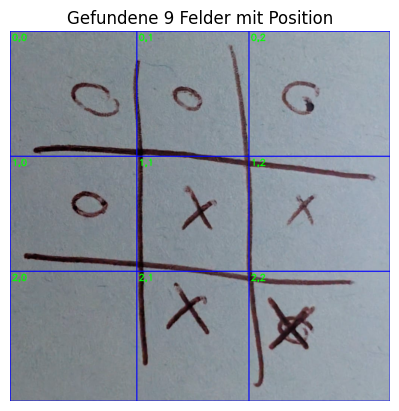

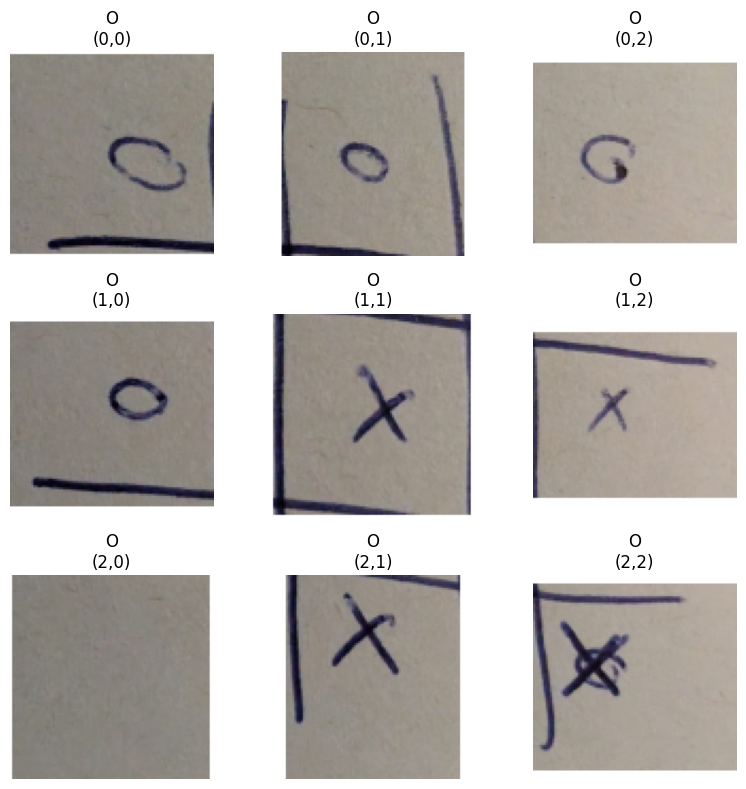

In [ ]:
def to_grayscale_and_binary(img, size=96):
    # In Graustufen und binär umwandeln, falls nötig
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Wieder adaptive threshold (wie oben)
    binary = cv2.adaptiveThreshold(
        gray,
        maxValue=255,
        adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        thresholdType=cv2.THRESH_BINARY_INV,
        blockSize=51,
        C=7
    )
    # Auf gewünschte Größe bringen, falls nötig (macht crop_and_resize_field aber meist schon)
    return cv2.resize(binary, (size, size), interpolation=cv2.INTER_AREA)

def show_9_classified_fields(field_bilder, positionen, size=96):
    if not field_bilder or not positionen:
        print("Keine Felder zum Anzeigen!")
        return
    fig, axs = plt.subplots(3, 3, figsize=(8, 8))
    for idx, (feld, pos) in enumerate(zip(field_bilder, positionen)):
        row, col = pos
        # Normiertes Feld erzeugen (wie bisher)
        norm_feld = crop_and_resize_field(feld, size=size)
        # Binärbild für Klassifikation erzeugen
        bin_feld = to_grayscale_and_binary(norm_feld, size=size)
        # Klassifikation durchführen
        label = classify_cell(bin_feld)
        axs[row, col].imshow(cv2.cvtColor(norm_feld, cv2.COLOR_BGR2RGB))
        axs[row, col].set_title(f"{label}\n({row},{col})")
        axs[row, col].axis('off')
    plt.tight_layout()
    plt.show()

# Beispiel-Aufruf für Klassifikation + Anzeige:
# ---- Muss nach Teil 1 und 2 ausgeführt werden ----
field_bilder, positionen = detect_tic_tac_toe_grid('Filled_Field1.png')
show_9_classified_fields(field_bilder, positionen, size=96)